import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform


In [11]:


class DataLoader:
    def __init__(self, base_dir, symbol, bar):
        self.base_dir = base_dir
        self.symbol = symbol
        self.bar = bar

    def load_single_file(self, file_path):
        df = pd.read_pickle(file_path)
        return df

    # def load_selected_files(self, file_indices):
    #     symbol_dir = os.path.join(self.base_dir, self.symbol)
    #     all_files = os.listdir(symbol_dir)
    #     selected_files = []
    #     for idx in file_indices:
    #         if f"{self.bar}" in all_files[idx]:
    #             selected_files.append(os.path.join(symbol_dir, all_files[idx]))
    #     with ThreadPoolExecutor() as executor:
    #         data = list(executor.map(self.load_single_file, selected_files))
#     return pd.concat(data)
    def load_selected_files(self, file_indices):
        """
                    Load selected data files based on the indices provided.

                    :param indices: List of indices corresponding to the files to load
                    :type indices: list
                    :return: DataFrame containing data from selected files
                    :rtype: pd.DataFrame
                    """
        symbol_dir = os.path.join(self.base_dir, self.symbol)
        all_files = os.listdir(symbol_dir)
        selected_files = []
        for idx in file_indices:
            if f"{self.bar}" in all_files[idx]:
                selected_files.append(os.path.join(symbol_dir, all_files[idx]))
        data = [self.load_single_file(file) for file in selected_files]
        return data

    def load_all_files(self):
        symbol_dir = os.path.join(self.base_dir, self.symbol)
        all_files = os.listdir(symbol_dir)
        selected_files = [os.path.join(symbol_dir, f) for f in all_files if f"{self.bar}" in f]
        with ThreadPoolExecutor() as executor:
            data = list(executor.map(self.load_single_file, selected_files))
        return data

In [18]:
def lag_shift_dataframe(data: pd.DataFrame, lag: int, columns_to_keep: list) -> pd.DataFrame:
    """
    Apply a lag shift to a DataFrame, keeping only specified columns, and returning both the original and lagged values.

    Args:
        data (pd.DataFrame): The input dataframe.
        lag (int): The number of periods to shift the data.
        columns_to_keep (list): A list of columns to keep and apply the shift to.

    Returns:
        combined_data (pd.DataFrame): The DataFrame containing the original and lagged values of the specified columns.
    """

    # Keep only the specified columns
    reduced_data = data[columns_to_keep]

    # Shift the remaining columns by the specified lag
    shifted_data = reduced_data.shift(lag)

    # Concatenate the original and shifted data
    combined_data = pd.concat([reduced_data, shifted_data], axis=1)

    # Update column names to indicate original and lagged values
    combined_data.columns = [f"{col}_orig" if i < len(columns_to_keep) else f"{col}_lag_{lag}" for i, col in enumerate(combined_data.columns)]


def lag_shift_all_lags_efficient(data: pd.DataFrame, max_lag: int, columns_to_keep: list) -> pd.DataFrame:
    """
    Apply multiple lag shifts to a DataFrame, keeping only specified columns, and returning both the original and lagged values.

    Args:
        data (pd.DataFrame): The input dataframe.
        max_lag (int): The maximum number of periods to shift the data.
        columns_to_keep (list): A list of columns to keep and apply the shift to.

    Returns:
        combined_data (pd.DataFrame): The DataFrame containing the original and lagged values of the specified columns for all lags up to max_lag.
    """

    # Keep only the specified columns
    reduced_data = data[columns_to_keep]

    # Apply lags from 1 to max_lag and join the lagged dataframes to the original data
    for lag in range(1, max_lag + 1):
        shifted_data = reduced_data.shift(lag).add_suffix(f"_lag{lag}")
        reduced_data = reduced_data.join(shifted_data)

    return reduced_data

    def lag_shift_multiple(data: pd.DataFrame, max_lag: int, columns_to_keep: list) -> pd.DataFrame:
        """
        Apply multiple lag shifts to a DataFrame, keeping only specified columns, and returning both the original and lagged values.

        Args:
            data (pd.DataFrame): The input dataframe.
            max_lag (int): The maximum number of periods to shift the data.
            columns_to_keep (list): A list of columns to keep and apply the shift to.

        Returns:
            combined_data (pd.DataFrame): The DataFrame containing the original and lagged values of the specified columns for all lags up to max_lag.
        """

        # Keep only the specified columns
        reduced_data = data[columns_to_keep]

        # Create a list to store dataframes with different lag values
        lag_dataframes = [reduced_data]

        # Apply lags from 1 to max_lag and append the lagged dataframes to the list
        for lag in range(1, max_lag + 1):
            shifted_data = reduced_data.shift(lag)
            shifted_data.columns = [f"{col}_lag{lag}" for col in shifted_data.columns]
            lag_dataframes.append(shifted_data)

        
        return lag_dataframes

In [206]:
def create_heatmap(df, tick_fontsize, save_plot=False, title=None, font_family='Verdana', font_size=12):
    """
    Takes a Pandas DataFrame as input and creates a heatmap using Seaborn.

    Args:
        df (pd.DataFrame): The input dataframe.
        tick_fontsize (int): The font size of the x and y tick labels.
        save_plot (bool): Whether to save the plot as a PNG file (default is False).
        title (str): The title of the heatmap (default is None).
        font_family (str): The font family of the values in the heatmap (default is 'Verdana').
        font_size (int): The font size of the values in the heatmap (default is 12).

    Returns:
        None.
    """
    # Set the font and color parameters
    plt.rcParams['font.sans-serif'] = font_family
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'

    # Create the heatmap
    plt.figure(figsize=(40, 32)) # Set the size of the figure
    ax = sns.heatmap(df.corr(), cmap='crest', annot=True, fmt='.2f', cbar=False, annot_kws={'fontsize':font_size, 'fontfamily':font_family})

    # Set the font size of the x and y tick labels
    ax.tick_params(axis='x', labelsize=tick_fontsize, rotation =45)
    ax.tick_params(axis='y', labelsize=tick_fontsize, rotation = 45)

    # Set the title of the heatmap
    if title:
        ax.set_title("", fontsize=14)

    # Save the plot as a high-quality PNG image
    if save_plot:
        plt.tight_layout()
        plt.savefig(f'{title}.png', dpi=300)

    # Show the plot
    plt.show()
    


def create_dendrogram(data, method='ward', metric='euclidean', title=None, figsize=(20, 16), save_plot=False):
    """
    Creates a dendrogram using hierarchical clustering of the input data.

    Args:
        data (pd.DataFrame): The input data.
        method (str): The clustering method to use (default is 'ward').
        metric (str): The distance metric to use (default is 'euclidean').
        title (str): The title of the dendrogram (default is None).
        figsize (tuple): The size of the figure (default is (10, 8)).
        save_plot (bool): Whether to save the plot as a PNG file (default is False).

    Returns:
        None.
    """
    # Check for missing or infinite values in the data
    if np.any(np.isnan(data)) or np.any(np.isinf(data)):
        # Replace missing or infinite values with the mean of the non-missing values
        data = data.replace([np.inf, -np.inf], np.nan).fillna(data.mean())

    # Compute the linkage matrix
    dissimilarity = 1 - abs(data)
    linkage_matrix = linkage(squareform(dissimilarity), 'complete')
    #linkage(data, method=method, metric=metric)

    # Create the dendrogram
    fig, ax = plt.subplots(figsize=figsize)
    dendrogram(linkage_matrix, ax=ax, labels=data.index, orientation='right',leaf_rotation=90)

    # Set the title of the dendrogram
    if title:
        ax.set_title("", fontsize=14)

    # Rotate the y-axis tick labels
    plt.xticks(rotation=45, fontsize =25)
     # Set the font size of the y-axis tick labels
    plt.yticks(fontsize=25, rotation =45)

    # Save the plot as a high-quality PNG image
    if save_plot:
        plt.tight_layout()
        plt.savefig(f'{title}.png', dpi=300)

    # Show the plot
    plt.show()
    
def plot_horizontal_boxplot_all_with_save(df,savefig=False,title=None, xticksize=10, yticksize=10):
    """
    Function to plot a horizontal boxplot for each column of the dataframe
    
    Arguments:
    df -- a pandas dataframe
    title -- a string representing the title of the plot (default is an empty string)
    savefig -- a boolean indicating whether to save the plot (default is False)
    xticksize -- an integer representing the size of the xticks (default is 10)
    yticksize -- an integer representing the size of the yticks (default is 10)
    
    Returns:
    None
    """
    sns.set_theme(style="ticks") # Set the Seaborn style to "ticks"
    color_palette = sns.color_palette("Set2", n_colors=len(df.columns), desat=.5) # Define a color palette with one color for each column
    
    fig, ax = plt.subplots(figsize=(16, len(df.columns))) # Create a new figure and axis for the plot
    sns.boxplot(data=df, orient="h", palette=color_palette) # Plot all horizontal boxplots in one plot with a different color for each column
    ax.set_ylabel("") # Set the y-axis label to an empty string
    sns.despine() # Remove the top and right spines
    
    ax.tick_params(axis='x', labelsize=xticksize,rotation =45) # Set the size of the xticks
    ax.tick_params(axis='y', labelsize=yticksize) # Set the size of the yticks
    
#     if title != "": # If a title is provided
#         ax.set_title(title) # Set the title of the plot
    
    if savefig: # If savefig is True
        if title == "": # If no title is provided, set the title to "horizontal_boxplot"
            title = "horizontal_boxplot"
        plt.savefig(title + ".png") # Save the plot as a PNG image
    
    plt.show() # Show the plot


In [271]:
base_path = "/media/ak/Data1/ExperimentData/August11th2022Experiments/ExperimentInputFiles"
symbol = "FB1"
bar = "dollar"
test_file = "JB1_dollar_20180420_exp_df.pkl"

select = [0, 1, 3]  # Select files to load by index

data_loader = DataLoader(base_path, symbol, bar)
data = data_loader.load_selected_files(select)
all_files = data_loader.load_all_files()

figures_path ='/home/ak/Documents/Research/Papers/StylisedFactsPaper/figures'

In [272]:
len(all_files)

137

In [273]:
list_of_variables = ['price_imbalance', 'weighted_activity_spread','median_traded_volume']

In [274]:
def main(list_of_files, lag, list_of_variables):
    f =[lag_shift_dataframe(f, lag, list_of_variables) for f in list_of_files]
    return f

def median_df(list_of_dataframes):
    median_df = pd.concat(list_of_dataframes).groupby(level=0).median()
    return median_df

In [275]:

list_of_dfs = main(all_files, 3, list_of_variables)

In [276]:
df_median = median_df(list_of_dfs)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


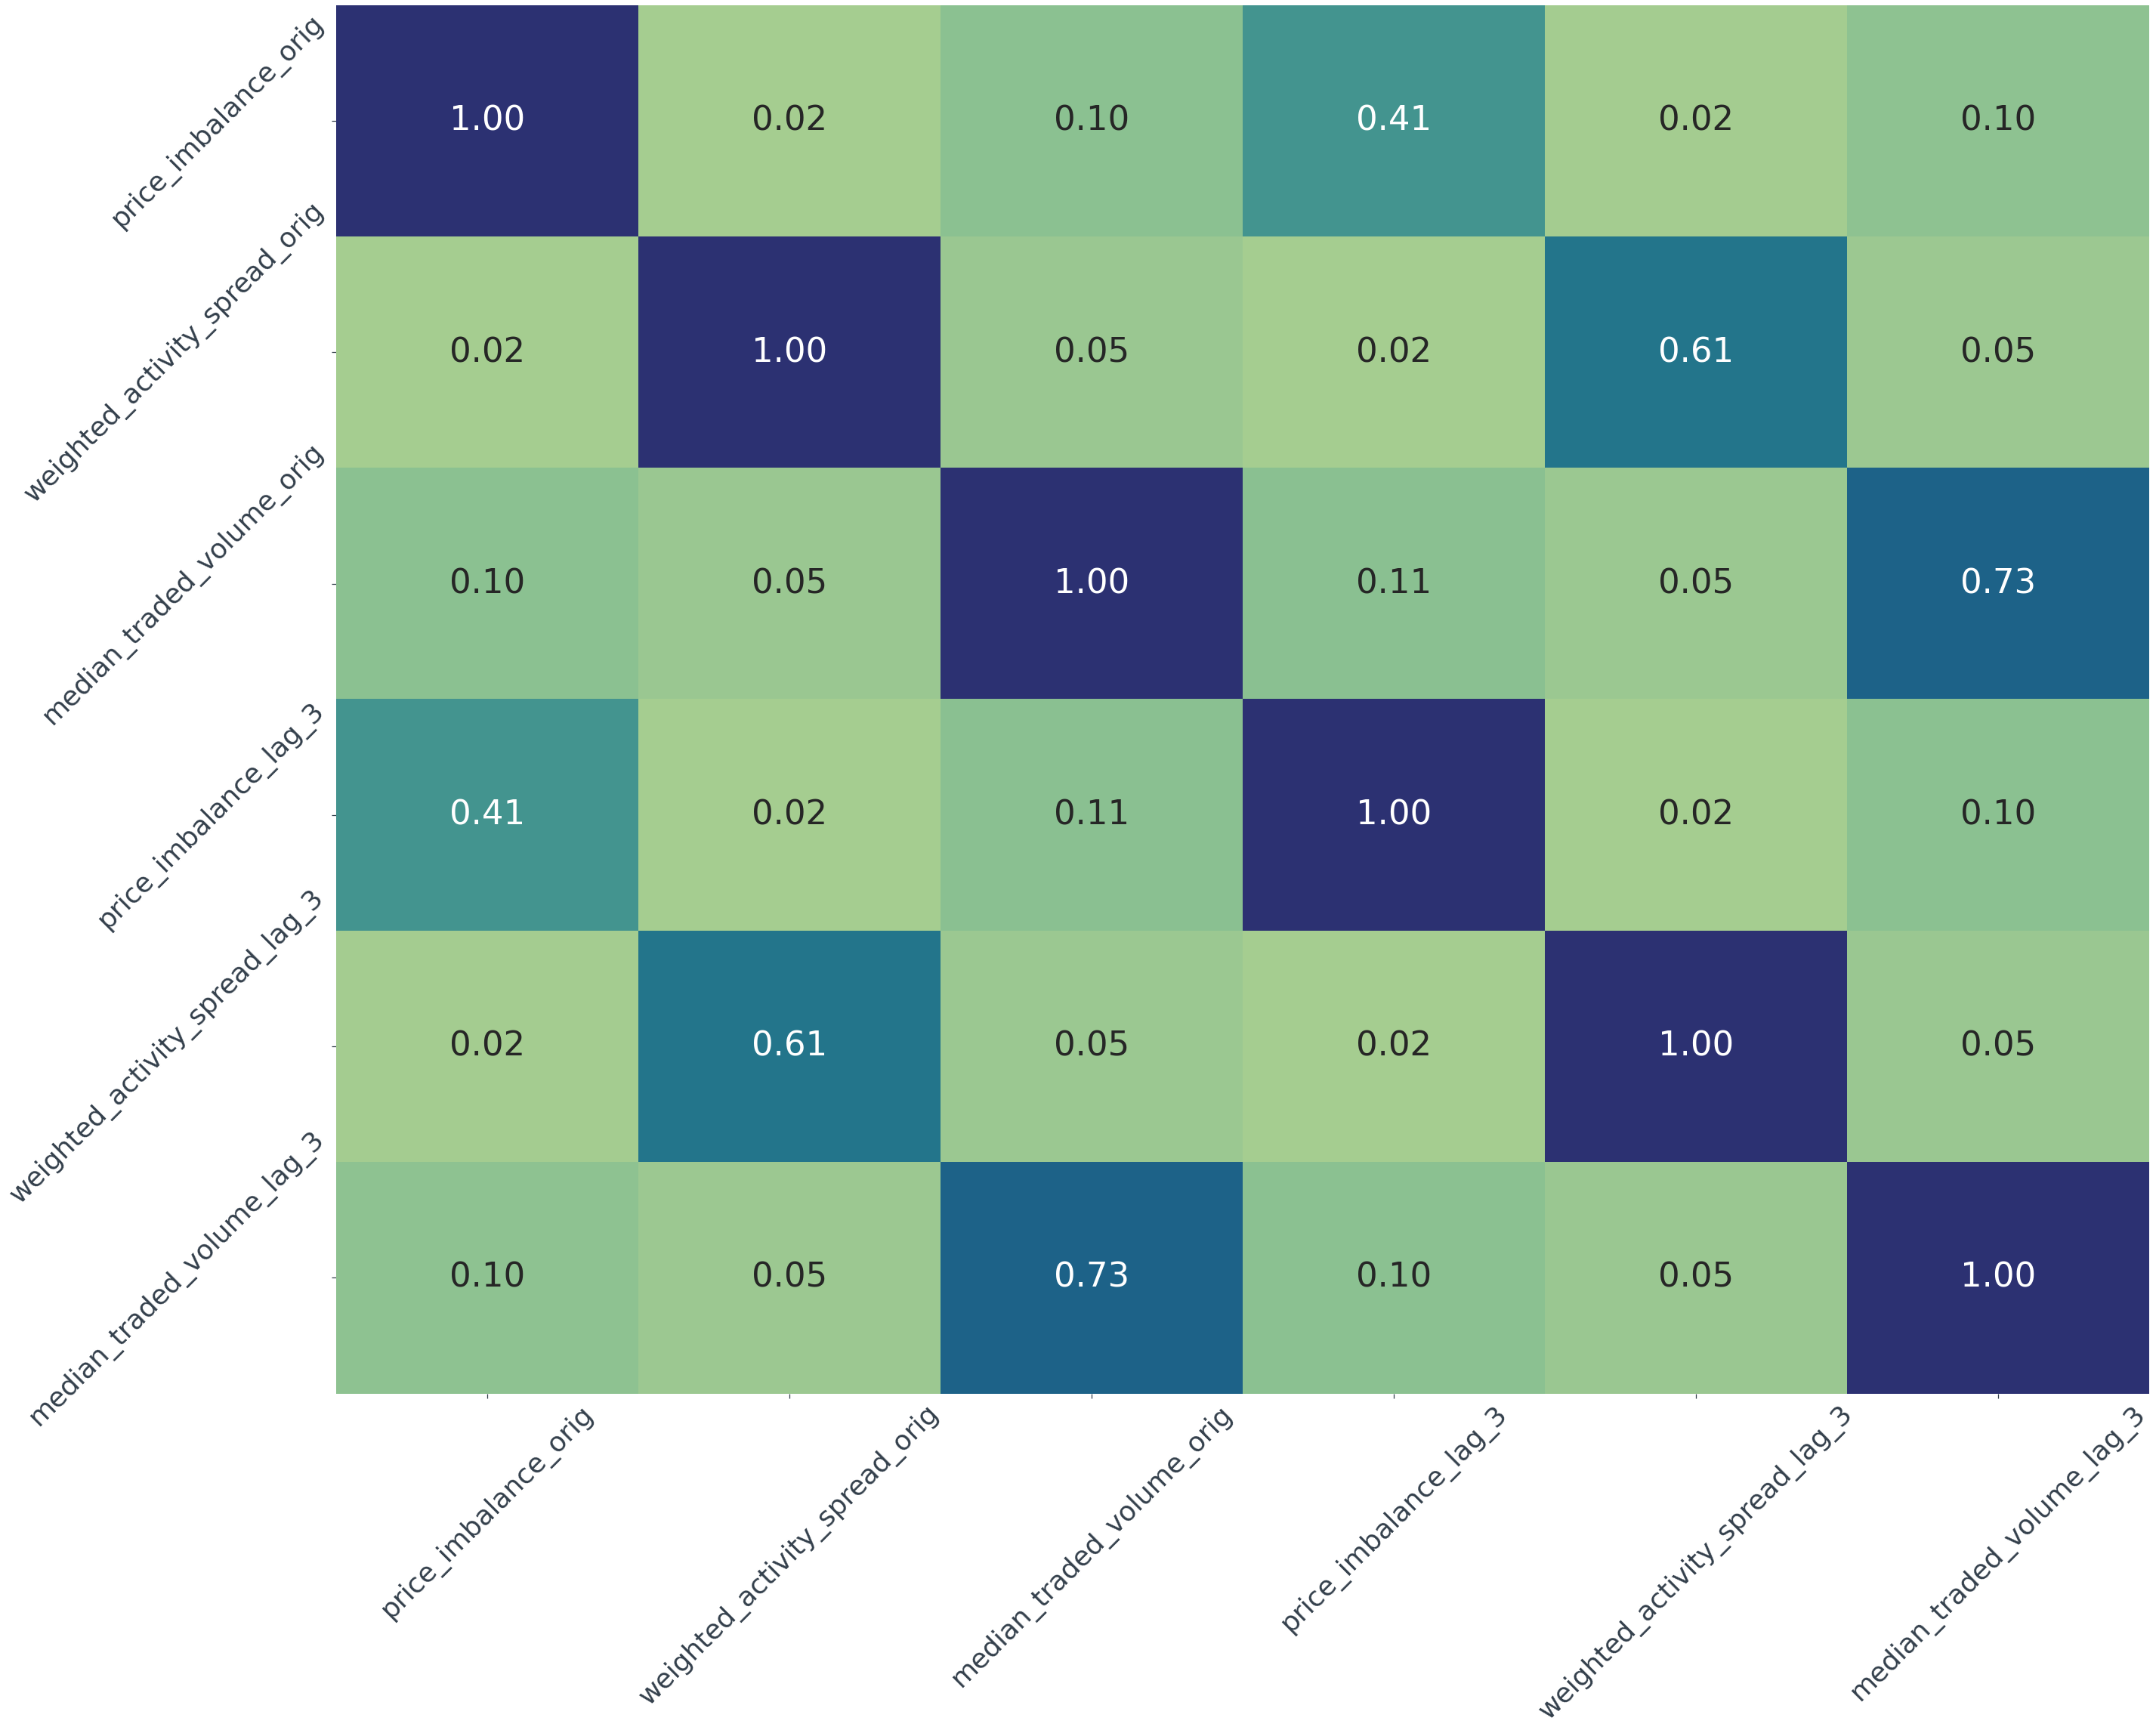

In [277]:
fileName = 'heatmap_'+str(symbol)+'_'+str(bar)+'_'+'.png'
plot_path_to_save = os.path.join(figures_path, fileName)
create_heatmap(df_median,tick_fontsize=36, save_plot = True, title = plot_path_to_save,  font_size =45)

In [278]:
corr_matrix = df_median.corr()
corr_matrix

,price_imbalance_orig,weighted_activity_spread_orig,median_traded_volume_orig,price_imbalance_lag_3,weighted_activity_spread_lag_3,median_traded_volume_lag_3
price_imbalance_orig,1.000000,0.016230,0.104283,0.411967,0.019616,0.098467
weighted_activity_spread_orig,0.016230,1.000000,0.054004,0.015498,0.608136,0.049722
median_traded_volume_orig,0.104283,0.054004,1.000000,0.110093,0.053337,0.729921
price_imbalance_lag_3,0.411967,0.015498,0.110093,1.000000,0.016492,0.104200
weighted_activity_spread_lag_3,0.019616,0.608136,0.053337,0.016492,1.000000,0.054054
median_traded_volume_lag_3,0.098467,0.049722,0.729921,0.104200,0.054054,1.000000


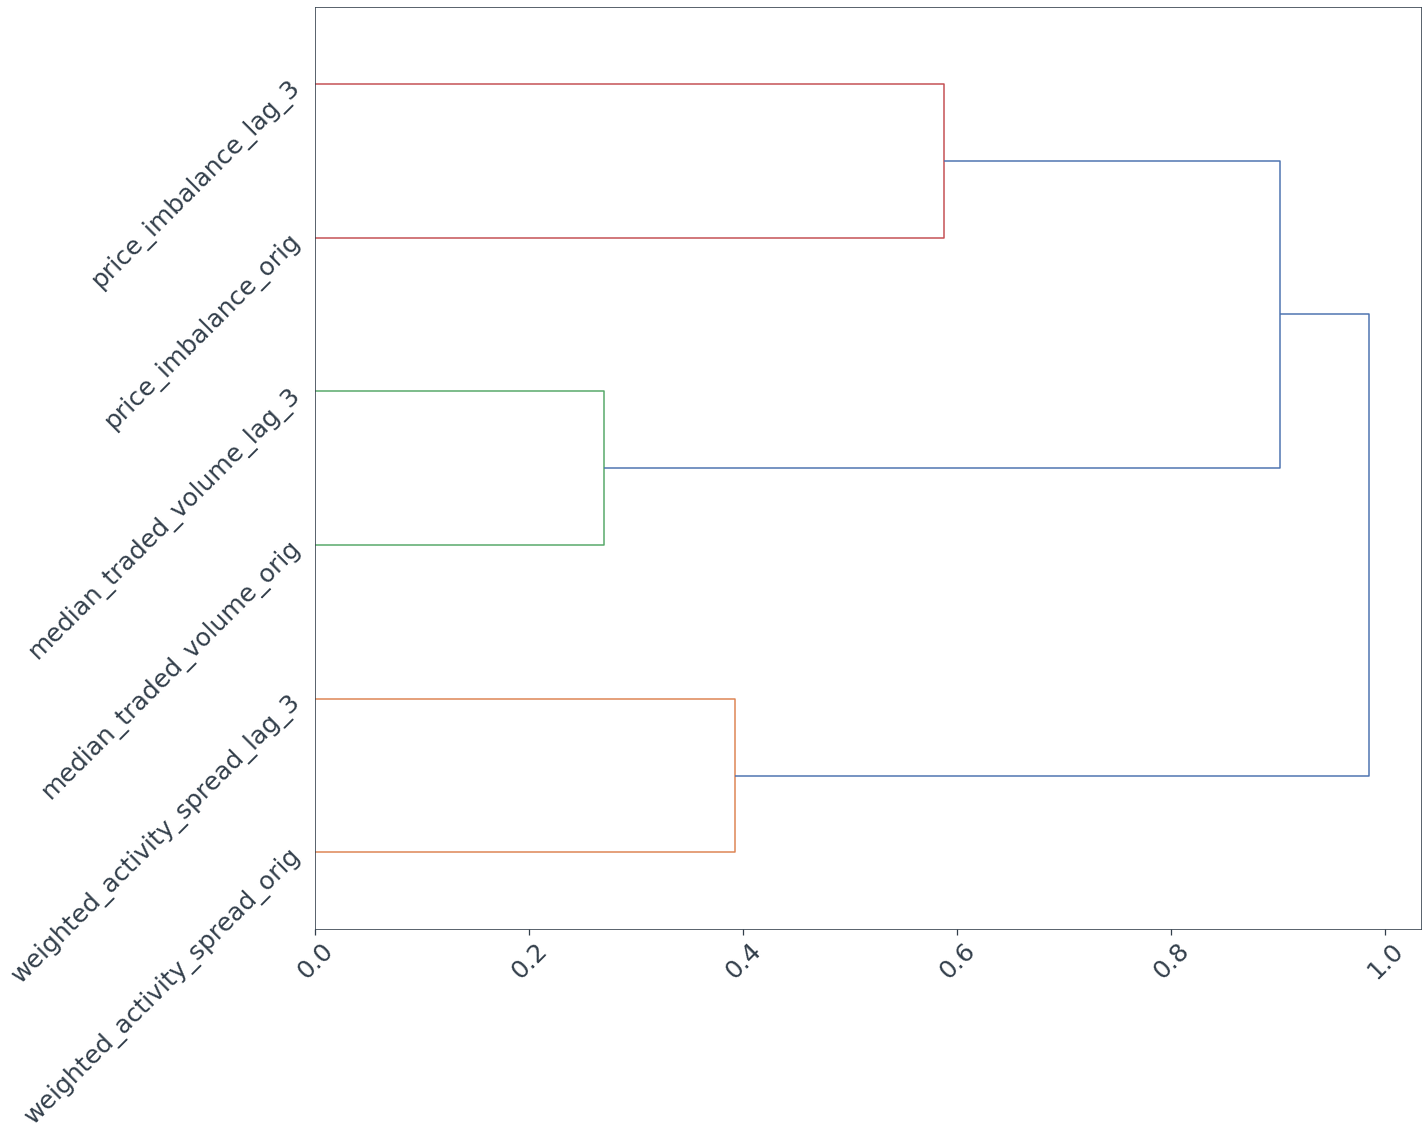

In [279]:
fileName = 'dendrogram_'+str(symbol)+'_'+str(bar)+'_'+'.png'
plot_path_to_save = os.path.join(figures_path, fileName)
_=create_dendrogram(corr_matrix, title=plot_path_to_save, save_plot=True)

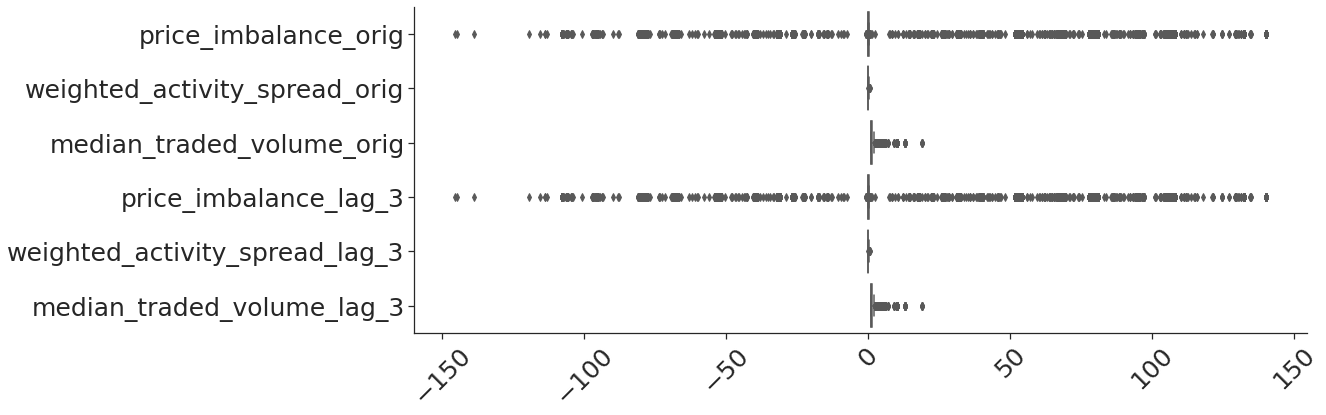

In [280]:
fileName = 'boxplot_lagged_vars_'+str(symbol)+'_'+str(bar)+'_'+'.png'
plot_path_to_save = os.path.join(figures_path, fileName)
_=plot_horizontal_boxplot_all_with_save(df_median, savefig=True, title=plot_path_to_save, xticksize= 25, yticksize=25)